<a href="https://colab.research.google.com/github/KazGet/Summer_prac/blob/main/Summer_practies_4_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
!pip install catboost
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.8 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive; drive.mount('/content/drive')
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, RocCurveDisplay, roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import Pipeline
!pip install optuna
import optuna
!pip install missforest
from missforest import MissForest
import shap
!pip install boruta
from boruta import BorutaPy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 15.4 MB/s eta 0:00:00


In [202]:
file = "/content/TASK_4.xlsx"
df = pd.read_excel(file, sheet_name=0)
#Задача - предсказание плохого прогноза — значение 1 в графе MH по данным стресс-ЭхоКГ — графы СR-GJ.
indices_to_drop = list(range(0, 95)) + list(range(192, 345)) + list(range(346, len(df.columns)))
df = df.drop(df.columns[indices_to_drop], axis=1)
df=df.drop(['DTE rest', 'Minutes Exercise', 'Sat O2 rest', "GLS RV rest", "GLS RV stress", 'DTE stress', 'SBP rest', 'IMM rest', 'S RV  stress'], axis=1)
categorical_features = ['Reason of Stress Stop', 'Peak ECG']
df[categorical_features] = df[categorical_features].fillna("NaN").astype(str)

X = df.drop('FU1+2+3 coronary event (Death+AMI+ACS+Revasc)', axis=1)
y = df['FU1+2+3 coronary event (Death+AMI+ACS+Revasc)']

mask = df['FU1+2+3 coronary event (Death+AMI+ACS+Revasc)'].isin([0, 1])
X = X[mask]
y = y[mask]

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_features] = encoder.fit_transform(X[categorical_features])
X.columns = X.columns.astype(str)
X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

In [7]:
# @title Удаление полупустых признаков и заполнение медианой
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.5].index
df_dropped = df.drop(cols_to_drop, axis=1)

X_dropped = df_dropped.drop('FU1+2+3 coronary event (Death+AMI+ACS+Revasc)', axis=1)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_dropped[categorical_features] = encoder.fit_transform(X_dropped[categorical_features])
X_dropped = X_dropped[mask]

imputer = SimpleImputer(strategy='median')
X_filled = imputer.fit_transform(X_dropped)
X_filled_data = pd.DataFrame(X_filled, columns=X_dropped.columns)

In [8]:
# @title Заполнение методом KNNImputer
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(X.select_dtypes(include=[np.number]))

imputer = KNNImputer(n_neighbors=10)
df_imputed_scaled = imputer.fit_transform(df_scaled)
df_KNN = scaler.inverse_transform(df_imputed_scaled)
df_final = pd.DataFrame(df_KNN, columns=X.columns)

In [9]:
# @title Заполнение пропусков методом Iterative Imputer
imputer = IterativeImputer(max_iter=25, random_state=0)
df_imputed = imputer.fit_transform(X)
df_MICE = pd.DataFrame(df_imputed, columns=X.columns)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [10]:
# @title Заполнение пропусков методом MissForest
mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_miss_forest = mf.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [08:53<00:00, 106.66s/it]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process

X_med: Компоненты, объясняющие 95% дисперсии = 38
df_KNN: Компоненты, объясняющие 95% дисперсии = 42
df_MICE: Компоненты, объясняющие 95% дисперсии = 41
df_MissForest: Компоненты, объясняющие 95% дисперсии = 42


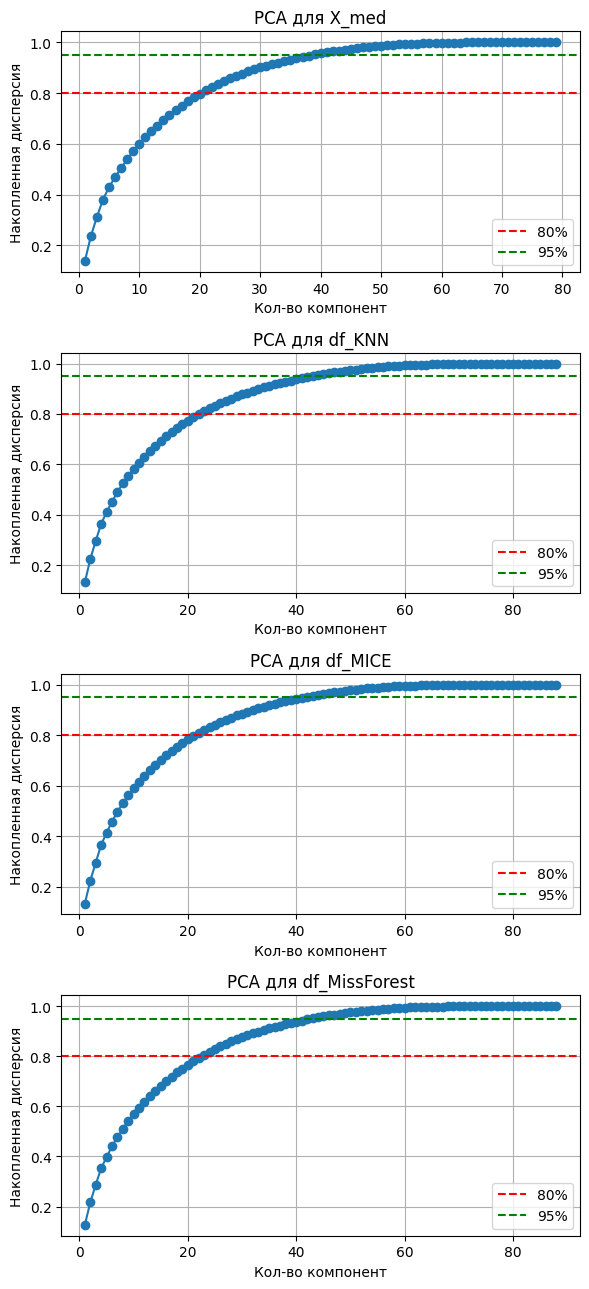

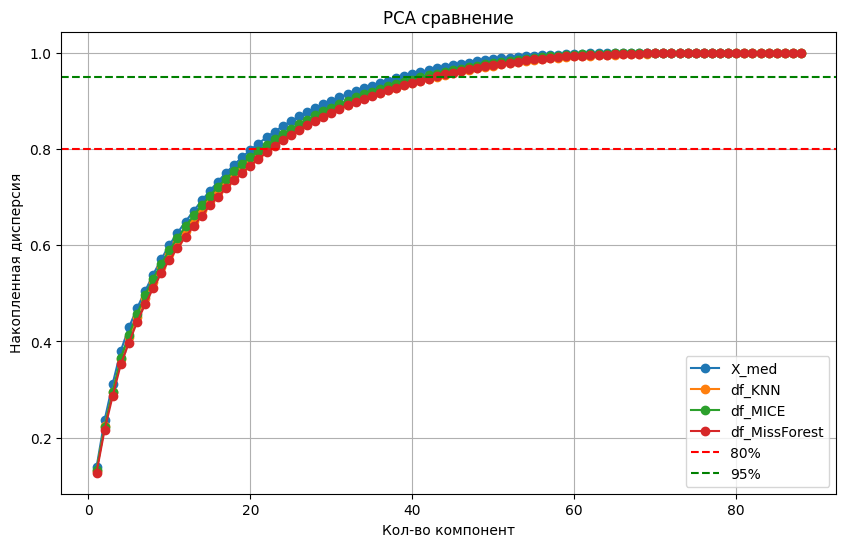

In [11]:
# @title PCA
fig, axes = plt.subplots(4, 1, figsize=(6, 13))

datasets = [
    ("X_med", X_filled_data),
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]


for ax, (name, data) in zip(axes, datasets):
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()


In [12]:
# @title Отбор признаков по матрице весов PCA
X_numeric = X_filled_data.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings_df = pd.DataFrame(
    data=pca.components_,
    columns=X_numeric.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
def get_most_important_features(component, loadings_df, n_features=1):
    pc_loadings = loadings_df.loc[component]
    most_important = pc_loadings.abs().sort_values(ascending=False).head(n_features)
    return loadings_df.loc[component, most_important.index]
    # return loadings_df.loc[component]

new_X = []
for i in range(1, 41):
  new_X.append(get_most_important_features(f'PC{i}', loadings_df))
  # print(get_most_important_features(f'PC{i}', loadings_df, n_features=1))

print(new_X)
# # Визуализируем нагрузки для первых 10 компонент
# plt.figure(figsize=(15, 8))
# sns.heatmap(loadings_df.head(10), cmap='vlag', annot=False) # annot=True, если признаков не слишком много
# plt.title('Тепловая карта нагрузок PCA (первые 10 компонент)')
# plt.show()

[LVEDV stress    0.268254
Name: PC1, dtype: float64, ABCDE score+ECG    0.320558
Name: PC2, dtype: float64, Diast dysfunc  range    0.251967
Name: PC3, dtype: float64, e'  stress    0.251798
Name: PC4, dtype: float64, A  stress    0.258725
Name: PC5, dtype: float64, GLS delta    0.352474
Name: PC6, dtype: float64, E rest    0.277674
Name: PC7, dtype: float64, ECG range    0.272866
Name: PC8, dtype: float64, B-lines stress    0.307773
Name: PC9, dtype: float64, delta EF    0.2972
Name: PC10, dtype: float64, HR rest    0.285303
Name: PC11, dtype: float64, LAD at rest    0.312574
Name: PC12, dtype: float64, LAD stress    0.294506
Name: PC13, dtype: float64, TAPSE  stress    0.25192
Name: PC14, dtype: float64, MR rest    0.335097
Name: PC15, dtype: float64, СFVR range    0.297752
Name: PC16, dtype: float64, DBP rest    0.29039
Name: PC17, dtype: float64, Diast dysfunc rest    0.345424
Name: PC18, dtype: float64, LAD stress    0.320346
Name: PC19, dtype: float64, LAD stress    0.352862
Name

In [77]:
# @title Рекурсивное исключение признаков (Recursive Feature Elimination, RFE): Модель обучается на всех признаках, затем самый неважный удаляется, и процесс повторяется.
select_num = 7
selector_med = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_med.fit(X_filled, y)
selected_features_med = X_dropped.columns[selector_med.get_support()]
print("Отобранные признаки для данных, заполенными медианой: ")
print(selected_features_med.tolist())

selector_KNN = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_KNN.fit(df_KNN, y)
selected_features_KNN = X.columns[selector_KNN.get_support()]
print(f"Отобранные признаки для данных, заполенными методом ближайших соседей: ")
print(selected_features_KNN.tolist())

selector_MICE = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MICE.fit(df_MICE, y)
selected_features_MICE = X.columns[selector_MICE.get_support()]
print(f"Отобранные признаки для данных, заполенными методом итеративного заполнения: ")
print(selected_features_MICE.tolist())

selector_MissF = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MissF.fit(df_miss_forest, y)
selected_features_MissF = X.columns[selector_MissF.get_support()]
print(f"Отобранные признаки для данных, заполенными методом MissForest: ")
print(selected_features_MissF.tolist())

print("\nПересечение всех признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE) & set(selected_features_MissF))

Отобранные признаки для данных, заполенными медианой: 
['LVESVi at rest', 'LV force rest', 'HR stress', 'HRR', 'LVESVi stress', 'LVEF% stress', 'D WMSI']
Отобранные признаки для данных, заполенными методом ближайших соседей: 
['LVESVi at rest', 'TR vel rest', 'HR stress', 'HRR', 'LVESVi stress', 'LVEF% stress', 'GLS stress-']
Отобранные признаки для данных, заполенными методом итеративного заполнения: 
['LVESVi at rest', 'HRR', 'LVESVi stress', 'LVEF% stress', 'GLS stress-', "s'  stress", 'RVSP  stress']
Отобранные признаки для данных, заполенными методом MissForest: 
['SI rest', 'GLS rest', 'LAVI rest', 'RA vol rest', 'HR stress', 'HRR', "s'  stress"]

Пересечение всех признаков: 
{'HRR'}


In [78]:
print("\nПересечение первых трех множеств признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE))


Пересечение первых трех множеств признаков: 
{'HRR', 'LVESVi stress', 'LVEF% stress', 'LVESVi at rest'}


In [126]:
# @title RFECV —  RFE с автоматическим выбором числа признаков через кросс-валидацию
df_test = df_MICE
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selector = RFECV(estimator=RandomForestClassifier(), step=1, cv=cv, scoring='accuracy', n_jobs=-1)
selector.fit(df_test, y)
selected_features = df_test.columns[selector.get_support()]
print("Оптимальное число признаков:", selector.n_features_)
print("Отобранные признаки:", selected_features.tolist())

Оптимальное число признаков: 34
Отобранные признаки: ['SBP rest', 'DBP rest', 'LVESVi at rest', 'SI rest', 'LV force rest', 'LAD at rest', 'GLS rest', 'RA vol rest', 'RAVI rest', 'E rest', 'S RV rest', 'TR vel rest', 'RVSP rest', 'HR stress', 'HRR', 'LVEDVi stress', 'LVESVi stress', 'LVEF% stress', 'delta EF', 'WMSI stress', 'LV force stress', 'GLS stress-', 'GLS reserve', 'GLS delta', 'LA vol  stress', 'A  stress', 'E/A stress', "e'  stress", "s'  stress", "E/e' stress", 'RVSP  stress', 'D WMSI', 'LV contractile reserve', 'CFVR']


In [79]:
# @title Отбор признаков методом ANOVA: оценка стат. связи между каждым признаком и целевой переменной
datasets = {
    "медианой": (X_filled, X_dropped.columns),
    "KNN": (df_KNN, X.columns),
    "MICE": (df_MICE, X.columns),
    "MF": (df_miss_forest, X.columns),
}

selected_features_all = {}

for name, (X_data, feature_names) in datasets.items():
    selector = SelectKBest(score_func=f_classif, k=select_num)
    X_selected = selector.fit_transform(X_data, y)
    selected = feature_names[selector.get_support()]
    selected_features_all[name] = set(selected)
    print(f"Отобранные признаки с данными {name}:\n{list(selected)}")

Отобранные признаки с данными медианой:
['WMSI stress', 'D WMSI', 'WMSI range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Отобранные признаки с данными KNN:
['WMSI stress', 'D WMSI', 'WMSI range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Отобранные признаки с данными MICE:
['WMSI stress', 'D WMSI', 'WMSI range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Отобранные признаки с данными MF:
['DBP rest', 'M

In [80]:
print("\nПересечение всех результатов (медиана ∩ KNN ∩ MICE):")
print(list(
    selected_features_all["медианой"]
    & selected_features_all["KNN"]
    & selected_features_all["MICE"]
))


Пересечение всех результатов (медиана ∩ KNN ∩ MICE):
['WMSI stress', 'D WMSI', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina', 'WMSI range']


In [17]:
# @title Отбор по LassoCV
def run_lasso_selection(X_source, y, name, feature_names):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso_cv', LassoCV(cv=5, max_iter=10000))
    ])

    pipeline.fit(X_source, y)
    best_alpha = pipeline.named_steps['lasso_cv'].alpha_

    print(f"\n{name}: наилучшее значение alpha = {best_alpha:.4f}")

    lasso = Lasso(alpha=best_alpha, max_iter=10000)
    X_scaled = StandardScaler().fit_transform(X_source)
    lasso.fit(X_scaled, y)

    non_zero_coefs = np.where(lasso.coef_ != 0)[0]
    selected = feature_names[non_zero_coefs]

    print(f"\nВыбранные признаки для {name}:\n", selected.tolist())
    return set(selected)

features_median = run_lasso_selection(X_filled, y, "Median", X_dropped.columns)
features_knn    = run_lasso_selection(df_KNN, y, "KNN", X.columns)
features_mice   = run_lasso_selection(df_MICE, y, "MICE", X.columns)
features_mf     = run_lasso_selection(df_miss_forest, y, "MissForest", X.columns)

print("\nПересечение всех признаков:")
intersection = features_median & features_knn & features_mice & features_mf
print(intersection)



Median: наилучшее значение alpha = 0.0279

Выбранные признаки для Median:
 ['LV force rest', 'LAD at rest', 'B-lines at rest', 'TAPSE rest', 'RVSP rest', 'HR stress', 'HRR', 'delta EF', 'WMSI stress', 'GLS stress-', 'GLS reserve', 'RVSP  stress', 'D WMSI', 'WMSI range', 'СFVR range', 'ABCDE score']

KNN: наилучшее значение alpha = 0.0321

Выбранные признаки для KNN:
 ['LV force rest', 'B-lines at rest', 'TAPSE rest', 'TR vel rest', 'RVSP rest', 'HR stress', 'HRR', 'delta EF', 'WMSI stress', 'SV stress', 'GLS stress-', 'D WMSI', 'WMSI range', 'СFVR range', 'ABCDE score']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03183578217349492, tolerance: 0.005739928057553956
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.134724050748801, tolerance: 0.005739928057553956
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006059551755804193, tolerance: 0.005739928057553956
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: 


MICE: наилучшее значение alpha = 0.0344

Выбранные признаки для MICE:
 ['LV force rest', 'B-lines at rest', 'TAPSE rest', 'TR vel rest', 'HR stress', 'HRR', 'delta EF', 'WMSI stress', 'GLS stress-', "e'  stress", "s'  stress", 'D WMSI', 'WMSI range', 'СFVR range', 'ABCDE score']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032399122050833284, tolerance: 0.005861870503597122
  model = cd_fast.enet_coordinate_descent_gram(



MissForest: наилучшее значение alpha = 0.0321

Выбранные признаки для MissForest:
 ['DBP rest', 'LVESV  rest', 'LVESVi at rest', 'LVEF% at rest', 'SI rest', 'GLS rest', 'LAVI rest', "E/e' rest", 'DBP stress', 'GLS stress-', 'E/A stress', "s'  stress", 'B range']

Пересечение всех признаков:
{'GLS stress-'}


In [131]:
# @title Объединение методов

#Удалим признаки с >50% пропусков
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.4].index
df_dropped = df.drop(cols_to_drop, axis=1)
X_d = df_dropped.drop('FU1+2+3 coronary event (Death+AMI+ACS+Revasc)', axis=1)
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_d[categorical_features] = encoder.fit_transform(X_d[categorical_features])
X_d = X_d[mask]

#Используем IterativeImputer для заполнения оставшихся признаков
mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_after_MF = mf.fit_transform(X_d)

imputer = IterativeImputer(max_iter=20, random_state=0)
df_after_MICE = imputer.fit_transform(X_d)
df_after_MICE = pd.DataFrame(df_after_MICE, columns=X_d.columns)

#Масшитабируем
X_numeric = df_after_MICE.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

X_numeric_ = df_after_MF.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled_ = scaler.fit_transform(X_numeric_)

#Сделаем отбор по методу RFE
selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled, y)
selected_features_MICE = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MICE: ")
print(selected_features_MICE.tolist())

selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled_, y)
selected_features_MF = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MF: ")
print(selected_features_MF.tolist())

#Сделаем отбор методом ANOVA
selector_ANOVA = SelectKBest(score_func=f_classif, k=select_num)
X_anova = selector_ANOVA.fit_transform(X_scaled, y)

selector_ANOVA_ = SelectKBest(score_func=f_classif, k=select_num)
X_anova_ = selector_ANOVA_.fit_transform(X_scaled_, y)

scores = selector_ANOVA.scores_
p_values = selector_ANOVA.pvalues_

scores = selector_ANOVA_.scores_
p_values = selector_ANOVA_.pvalues_

selected_featuresMICE = X_d.columns[selector_ANOVA.get_support()]
print(f"\nОтобранные признаки методом ANOVA:\n {list(selected_featuresMICE)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MICE) & set(selected_featuresMICE))

selected_featuresMF = X_d.columns[selector_ANOVA_.get_support()]
print(f"\nОтобранные признаки методом ANOVA (MF):\n {list(selected_featuresMF)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MF) & set(selected_featuresMF))

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [06:17<00:00, 75.43s/it]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process 

Отобранные признаки методом RFE+MICE: 
['LVESVi at rest', 'LV force rest', 'GLS rest', 'TR vel rest', 'HR stress', 'HRR', 'LVESVi stress', 'LVEF% stress', 'GLS stress-', 'E/A stress', 'D WMSI', 'LV contractile reserve']
Отобранные признаки методом RFE+MF: 
['MM rest', 'LVESVi at rest', 'B-lines at rest', 'LA vol rest', 'E rest', "E/e' rest", 'SBP stress', 'LVEDV stress', 'Diast dysfunc  stress', 'LV contractile reserve', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score+ECG']

Отобранные признаки методом ANOVA:
 ['Reason of Stress Stop', 'HR stress', 'HRR', 'delta EF', 'Delta EF >=5 - 0, <5 - 1', 'WMSI stress', 'D WMSI', 'WMSI range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score', 'ABCDE score+ECG', 

In [132]:
print(set(selected_features_MICE) & set(selected_featuresMICE) & set(selected_features_MF) & set(selected_featuresMF))

set()


Accuracy: 0.5857142857142857
Recall: 0.3181818181818182

Classification report:
               precision    recall  f1-score   support

         0.0       0.69      0.71      0.70        48
         1.0       0.33      0.32      0.33        22

    accuracy                           0.59        70
   macro avg       0.51      0.51      0.51        70
weighted avg       0.58      0.59      0.58        70


Confusion matrix:
 [[34 14]
 [15  7]]
ROC AUC (Train): 0.9074977141115513
ROC AUC: 0.5568181818181818


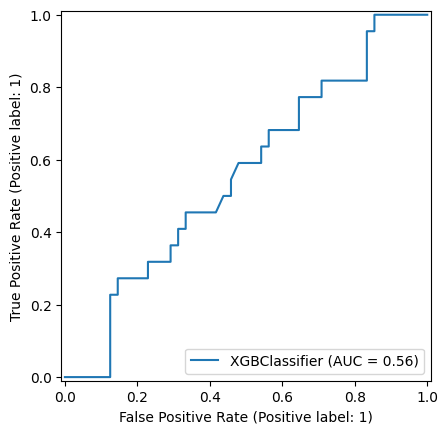

<Figure size 2000x1200 with 0 Axes>

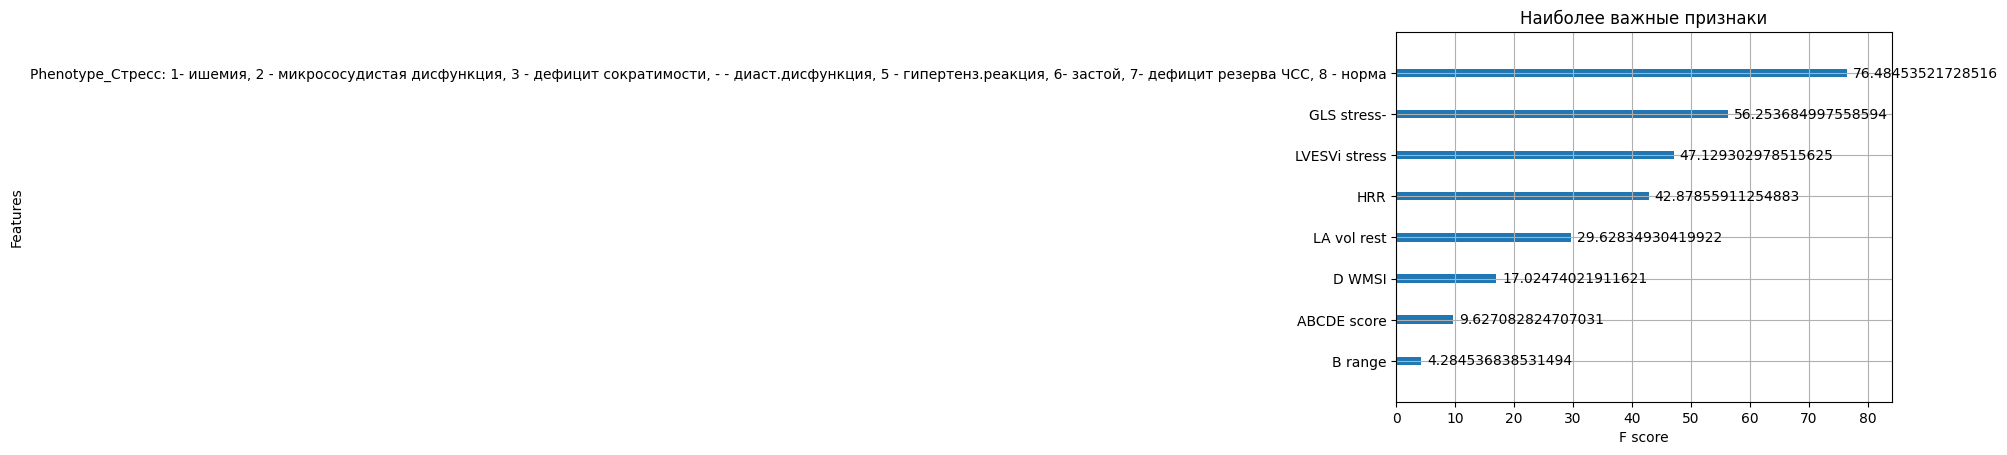

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


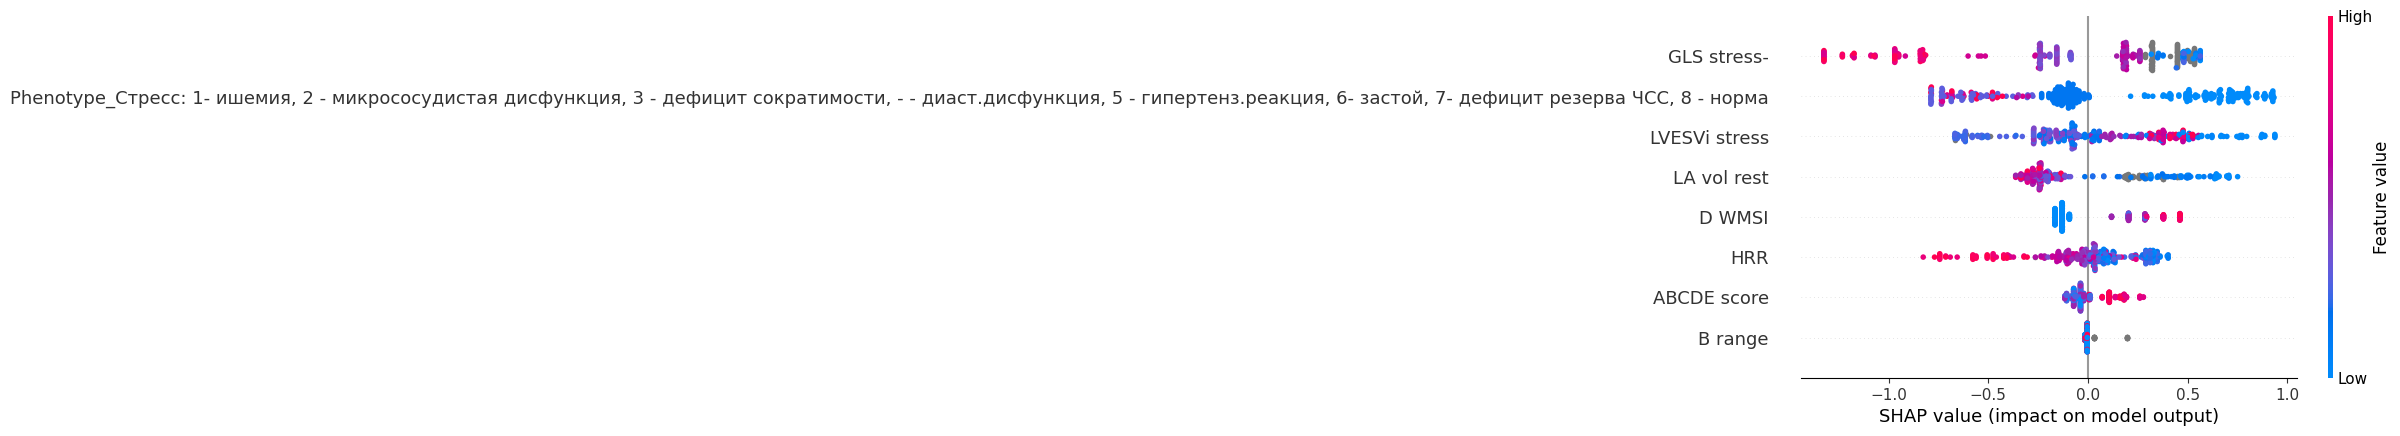

In [257]:
# @title XGBoost
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_features] = encoder.fit_transform(X[categorical_features])
X.columns = X.columns.astype(str)
X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

# optimal_cols =   ['ABCDE score+ECG', 'HRR', 'WMSI stress', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма',
                  # 'delta EF']

# optimal_cols = ['LVEDV stress', 'ABCDE score+ECG',  "e'  stress", 'A  stress', 'GLS delta', 'E rest', 'ECG range', 'B-lines stress', 'delta EF', 'HR rest']

# optimal_cols = ['SI rest', 'GLS rest', 'LAVI rest', 'HR stress', 'HRR', "s'  stress", ]
optimal_cols = ['D WMSI', 'HRR', 'LVESVi stress', 'GLS stress-', 'ABCDE score', 'LA vol rest', 'B range',
                'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма',
                ]

X_boost=X[optimal_cols]

X_train, X_test, y_train, y_test = train_test_split(X_boost, y, stratify=y, random_state=42, test_size=0.2)
neg = len(y_train[y_train == 0])  # или sum(y_train == 0)
pos = len(y_train[y_train == 1])  # или sum(y_train == 1)
scale_pos_weight = neg / pos
params = {'max_depth': 8, 'learning_rate': 0.38830158686351, 'n_estimators': 188, 'min_child_weight': 2, 'gamma': 2.5968539032497118, 'subsample': 0.9070492409605632, 'colsample_bytree': 0.7562826912266845, 'reg_alpha': 1.319550703563934, 'reg_lambda': 5.973831576646422, 'scale_pos_weight': scale_pos_weight}

model = XGBClassifier(**params)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

plt.figure(figsize=(20, 12))
plot_importance(model, max_num_features=len(optimal_cols), importance_type='total_gain')
plt.title("Наиболее важные признаки")
plt.show()
print()
explainer = shap.Explainer(model, X_boost)
shap_values = explainer(X_boost)
shap.summary_plot(shap_values, X_boost)

0:	learn: 0.6321839	total: 637us	remaining: 73.3ms
25:	learn: 0.5977011	total: 12.3ms	remaining: 42.6ms
50:	learn: 0.6551724	total: 23.1ms	remaining: 29.5ms
75:	learn: 0.6896552	total: 34.6ms	remaining: 18.2ms
100:	learn: 0.7011494	total: 45.9ms	remaining: 6.82ms
115:	learn: 0.6896552	total: 52.8ms	remaining: 0us
Accuracy: 0.8
Recall: 0.7

Classification report:
               precision    recall  f1-score   support

         0.0       0.88      0.84      0.86        50
         1.0       0.64      0.70      0.67        20

    accuracy                           0.80        70
   macro avg       0.76      0.77      0.76        70
weighted avg       0.81      0.80      0.80        70


Confusion matrix:
 [[42  8]
 [ 6 14]]
ROC AUC (Train): 0.9170126978395619
ROC AUC: 0.77


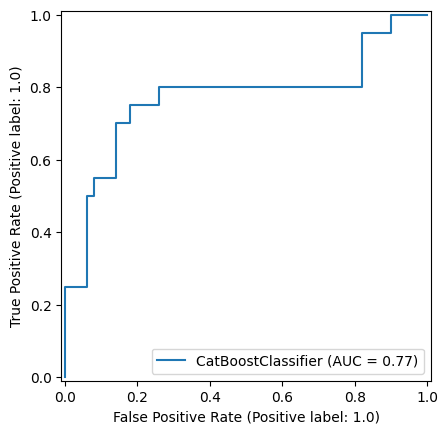

GLS stress-: 17.6315
D WMSI: 16.8758
HRR: 15.7174
LVESVi stress: 15.1922
ABCDE score: 10.8817
Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма: 10.2160
LA vol rest: 9.2511
B range: 4.2344


In [256]:
# @title CatBoostClassifier
# optimal_cols =   ['HRR', 'WMSI stress', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма',
#                   'delta EF']

optimal_cols = ['D WMSI', 'HRR', 'LVESVi stress', 'GLS stress-', 'ABCDE score', 'LA vol rest', 'B range',
                'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма',
                ]

X_boost = X[optimal_cols]
X_train, X_test, y_train, y_test = train_test_split(
    X_boost, y,
    test_size=0.2,
    random_state=0,
    shuffle=True
)
train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

params =  {'iterations': 116, 'learning_rate': 0.10155568960633561, 'depth': 5, 'l2_leaf_reg': 9.663540417193897, 'random_strength': 8.373440044547419,
           'bagging_temperature': 0.5976094384513785, 'border_count': 203, 'scale_pos_weight': 1.9009161493837594, "loss_function": "Logloss", "eval_metric": "Recall", "verbose":25}

model = CatBoostClassifier(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Вывод важности признаков
for i in range(len(X_boost.columns)):
    print(f"{X_boost.columns[indices[i]]}: {importances[indices[i]]:.4f}")

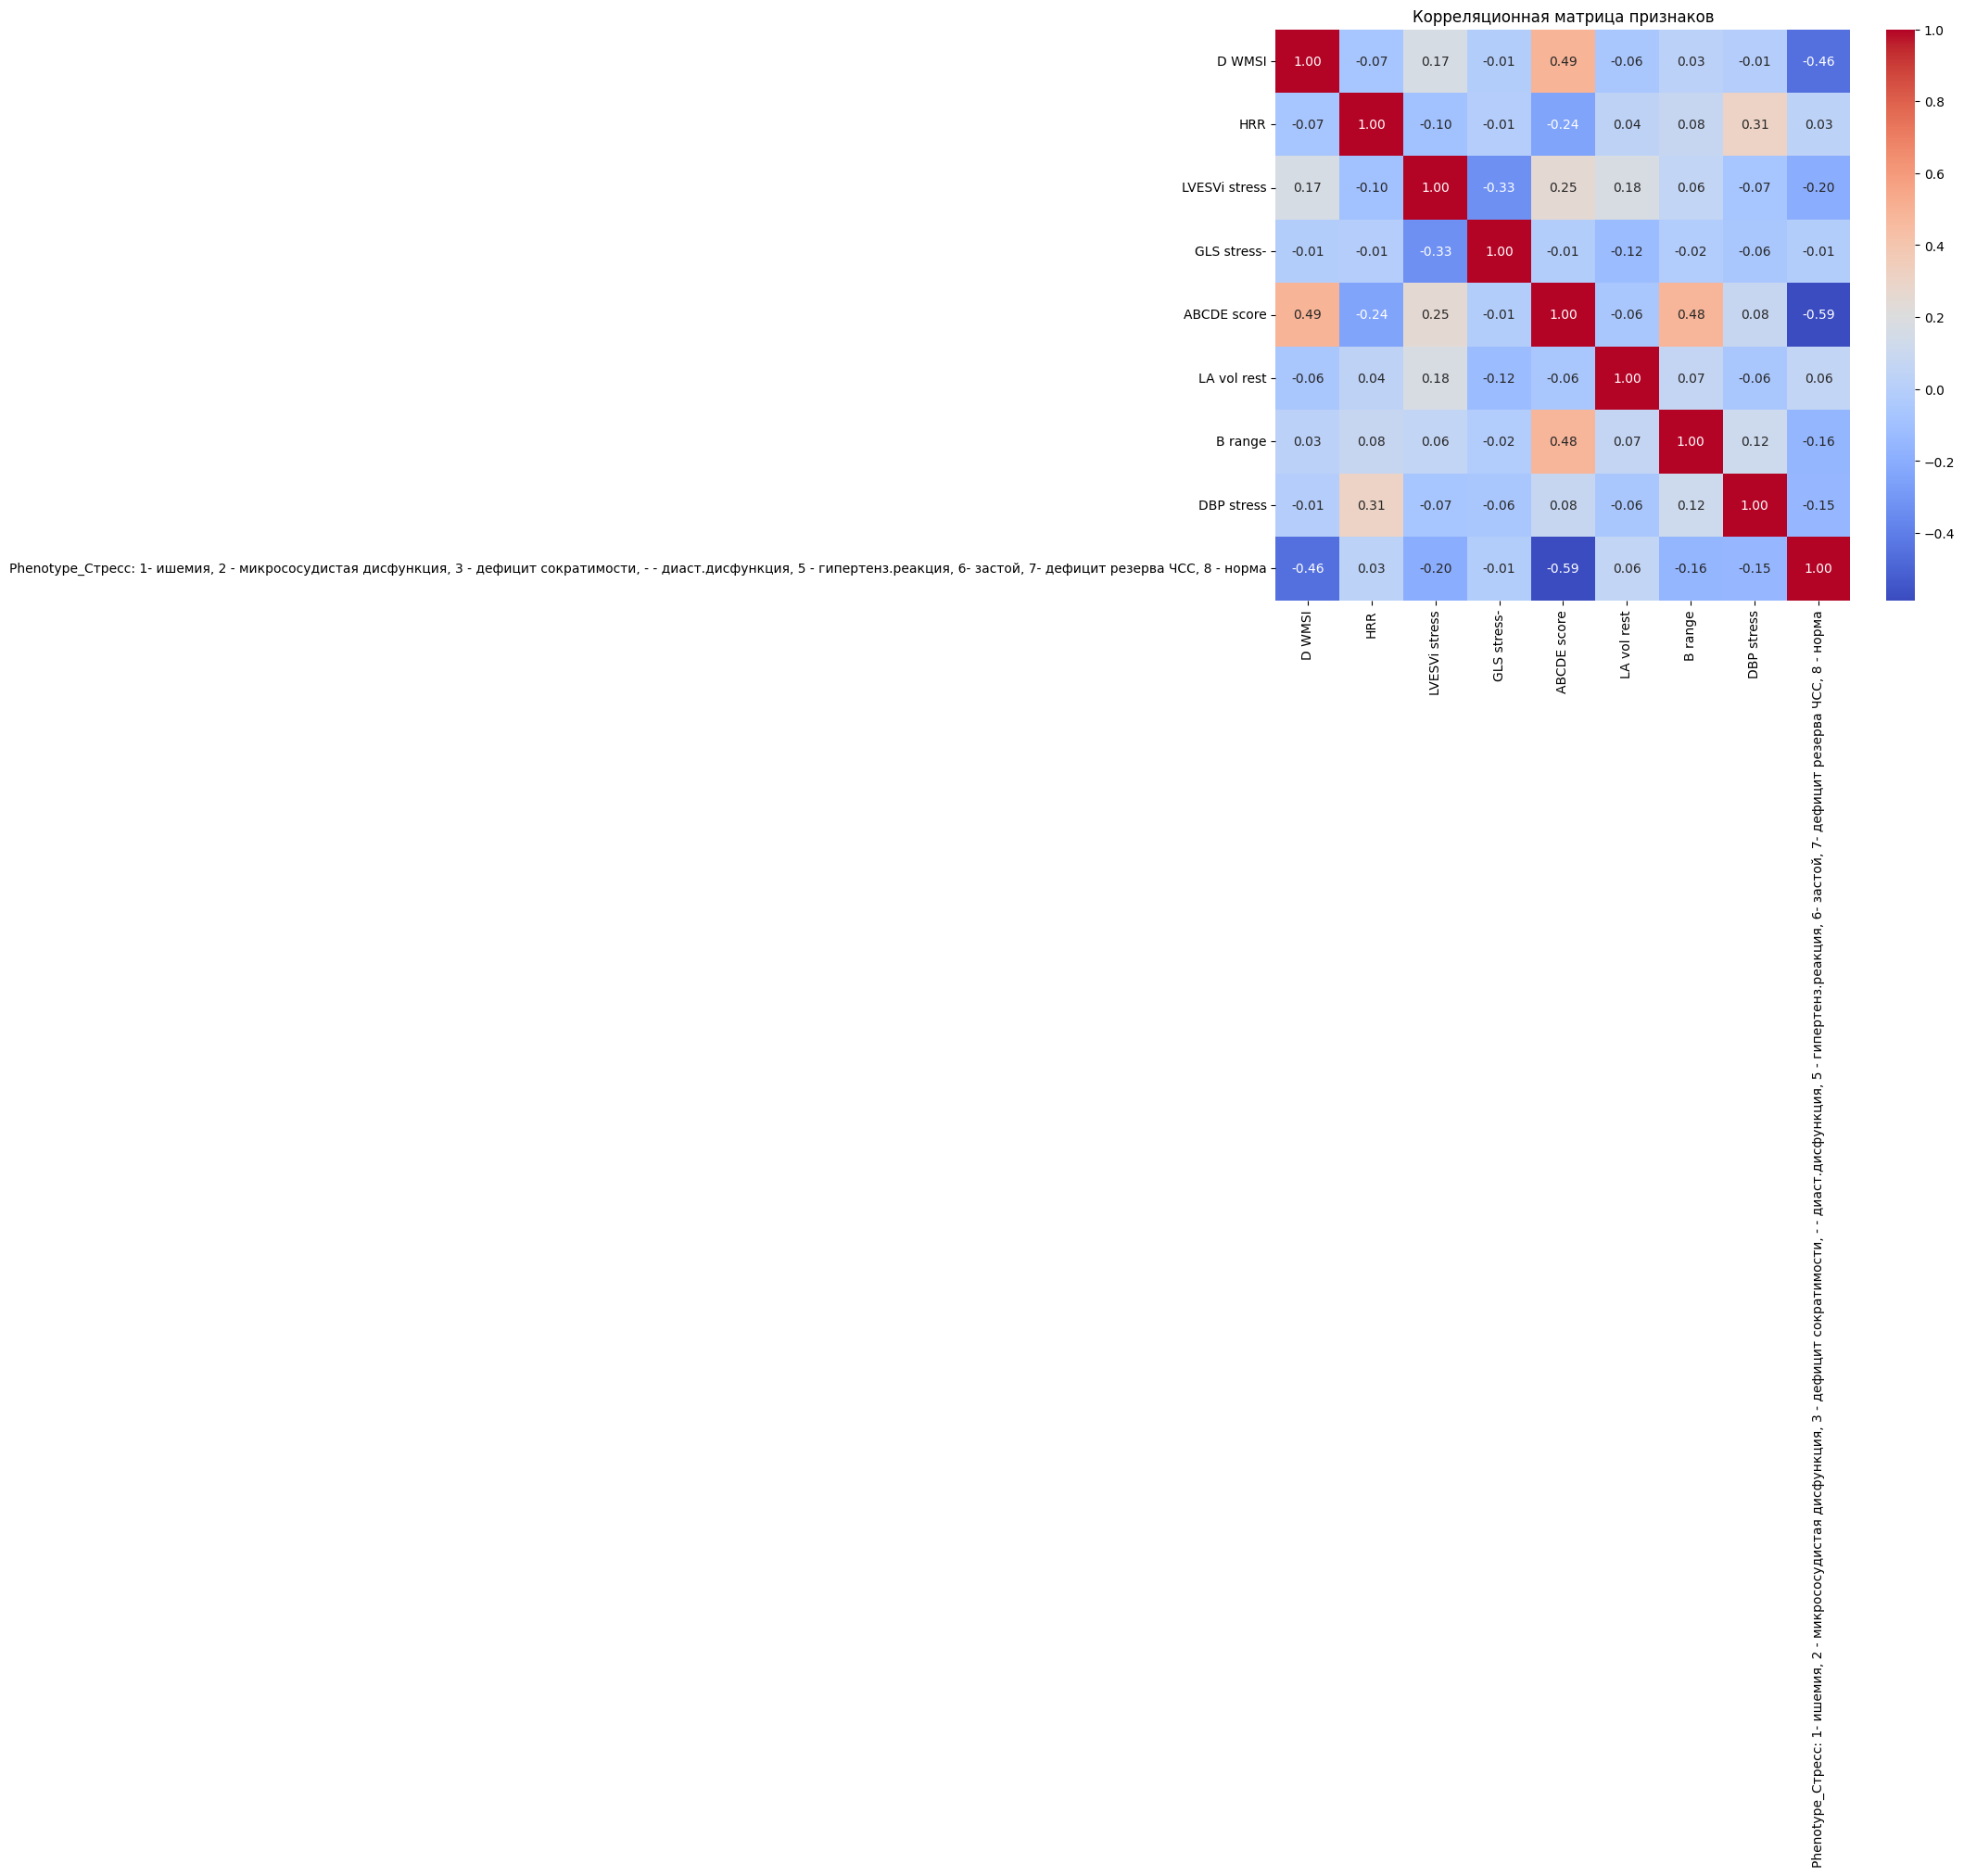

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


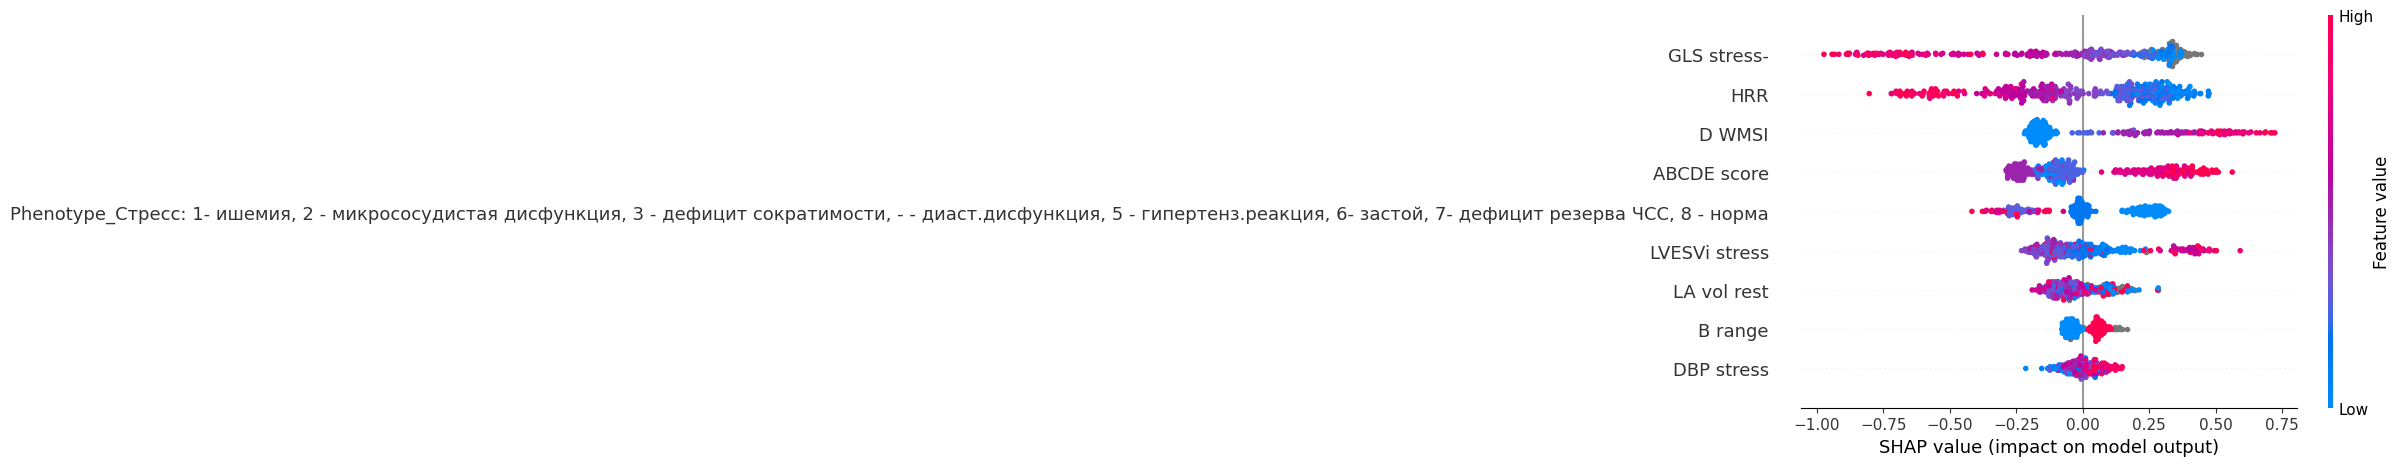

In [239]:
# @title Матрица корреляции для отобранных признаков и Shap
corr_matrix = X_boost.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица признаков')
plt.show()

print("\n")
explainer = shap.Explainer(model, X_boost)
shap_values = explainer(X_boost)
shap.summary_plot(shap_values, X_boost)

df_KNN: Компоненты, объясняющие 95% дисперсии = 4
df_MICE: Компоненты, объясняющие 95% дисперсии = 4
df_MissForest: Компоненты, объясняющие 95% дисперсии = 4


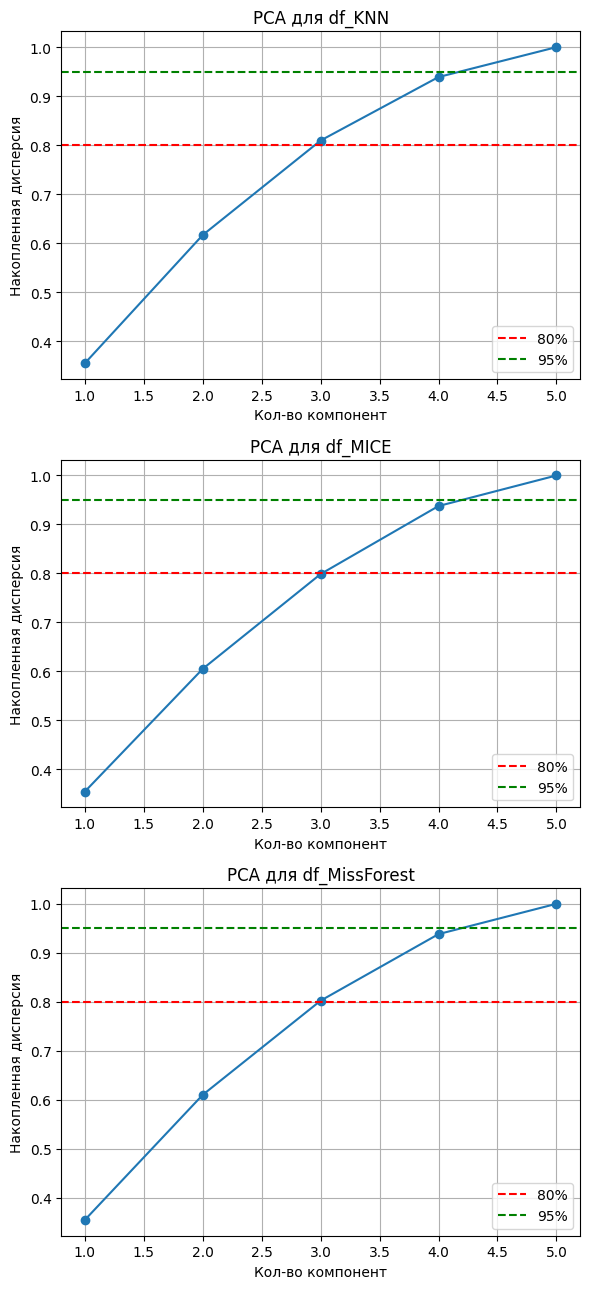

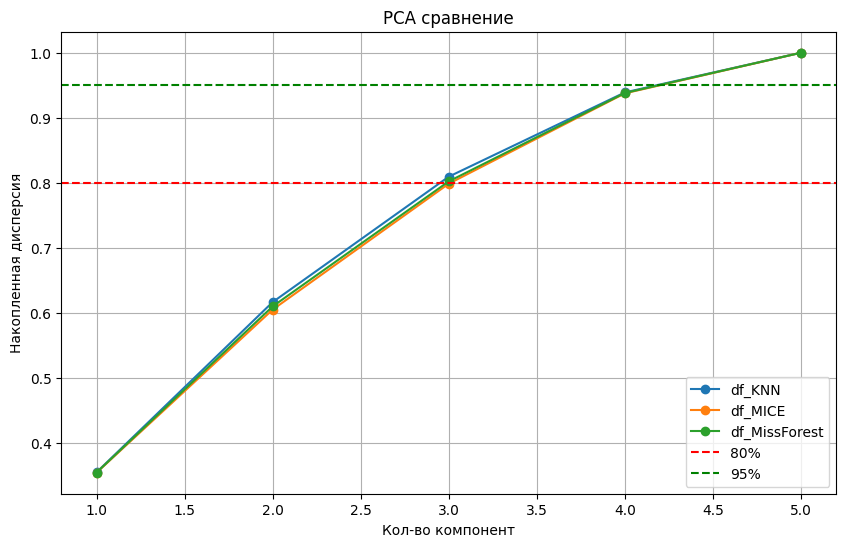

In [143]:
# @title PCA для отобранных признаков
fig, axes = plt.subplots(3, 1, figsize=(6, 13))

datasets = [
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]

for ax, (name, data) in zip(axes, datasets):
    data=data[optimal_cols]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    data=data[optimal_cols]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()


ABCDE score    0.595195
Name: PC1, dtype: float64
GLS stress-    0.61513
Name: PC2, dtype: float64
B range    0.706114
Name: PC3, dtype: float64
HRR    0.749308
Name: PC4, dtype: float64
LA vol rest    0.722558
Name: PC5, dtype: float64
LVESVi stress    0.674953
Name: PC6, dtype: float64
Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма    0.730316
Name: PC7, dtype: float64
ABCDE score    0.76118
Name: PC8, dtype: float64


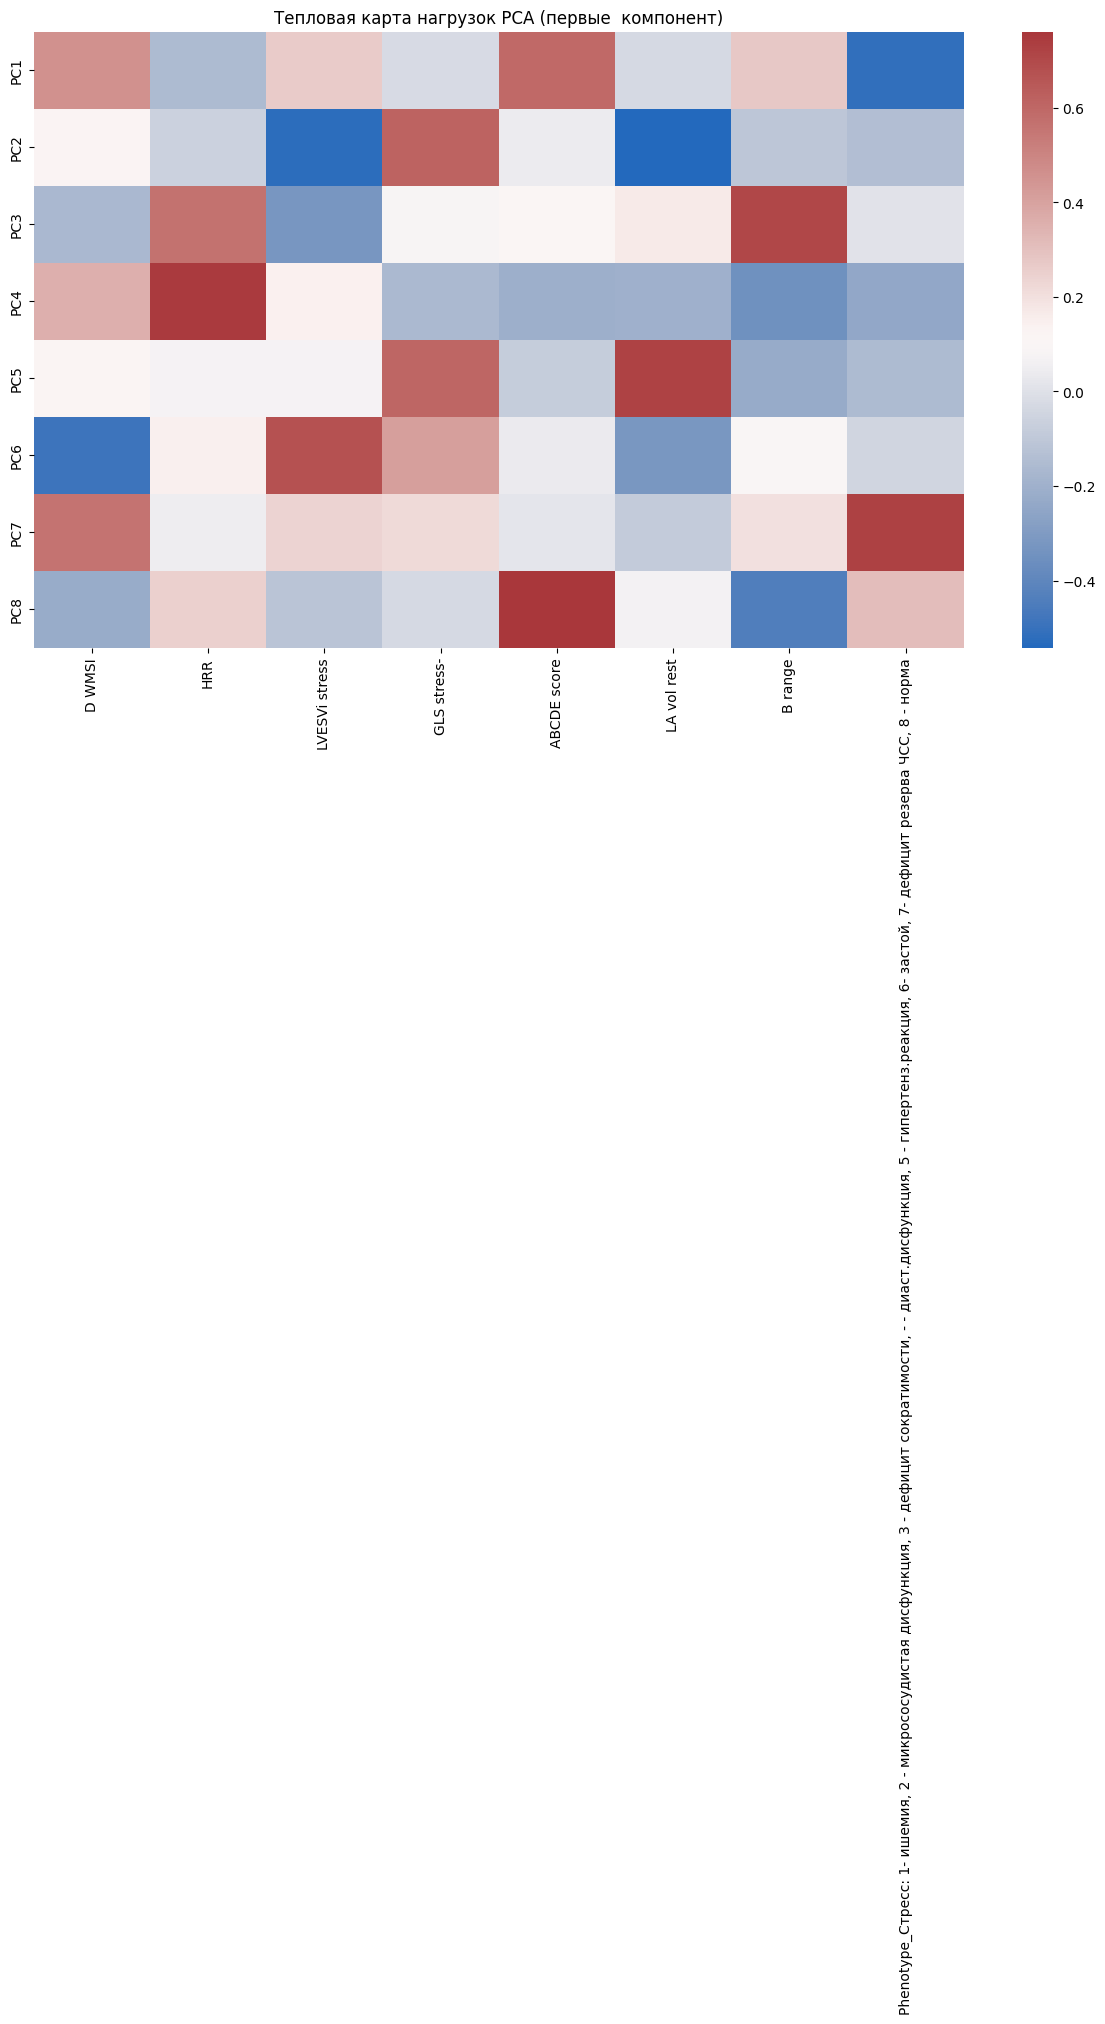

In [226]:
# @title Веса главных компонент по всем признакам
data=df_MICE[optimal_cols]
X_numeric = data.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings_df = pd.DataFrame(
    data=pca.components_,
    columns=X_numeric.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
def get_most_important_features(component, loadings_df, n_features=1):
    pc_loadings = loadings_df.loc[component]
    most_important = pc_loadings.abs().sort_values(ascending=False).head(n_features)
    return loadings_df.loc[component, most_important.index]

for i in range(1,len(data.columns)+1):
  print(get_most_important_features(f'PC{i}', loadings_df, n_features=1))

plt.figure(figsize=(15, 8))
sns.heatmap(loadings_df.head(10), cmap='vlag', annot=False)
plt.title('Тепловая карта нагрузок PCA (первые  компонент)')
plt.show()

[I 2025-07-11 08:08:57,482] A new study created in memory with name: no-name-75943182-455e-4660-9637-6a5dfa7fd1d1
[I 2025-07-11 08:08:59,625] Trial 0 finished with value: 0.614787543805401 and parameters: {'max_depth': 7, 'learning_rate': 0.059552267417850205, 'n_estimators': 156, 'min_child_weight': 3, 'gamma': 1.7779655596502941, 'subsample': 0.560620933358503, 'colsample_bytree': 0.9427986578950709, 'reg_alpha': 2.1548530006283464, 'reg_lambda': 8.551392399867837, 'scale_pos_weight': 0.8470437965903647}. Best is trial 0 with value: 0.614787543805401.
[I 2025-07-11 08:08:59,740] Trial 1 finished with value: 0.6344648194775745 and parameters: {'max_depth': 6, 'learning_rate': 0.032679948528807325, 'n_estimators': 24, 'min_child_weight': 4, 'gamma': 0.8856904639033814, 'subsample': 0.9540522907526185, 'colsample_bytree': 0.9364790823303335, 'reg_alpha': 3.86627275867895, 'reg_lambda': 2.3302542533997403, 'scale_pos_weight': 0.5924477476137999}. Best is trial 1 with value: 0.63446481947

Best trial:
AUC: 0.6702665319374503
Params: {'max_depth': 7, 'learning_rate': 0.12668602990424876, 'n_estimators': 165, 'min_child_weight': 7, 'gamma': 1.1937908670932833, 'subsample': 0.9232098571001475, 'colsample_bytree': 0.9984837128729486, 'reg_alpha': 4.545561810162807, 'reg_lambda': 2.30401540999619, 'scale_pos_weight': 0.9130879761167617}
Accuracy: 0.6857142857142857
Recall: 0.0

Classification report:
               precision    recall  f1-score   support

         0.0       0.69      1.00      0.81        48
         1.0       0.00      0.00      0.00        22

    accuracy                           0.69        70
   macro avg       0.34      0.50      0.41        70
weighted avg       0.47      0.69      0.56        70


Confusion matrix:
 [[48  0]
 [22  0]]
ROC AUC (Train): 0.7513258153002135
ROC AUC: 0.6122159090909092


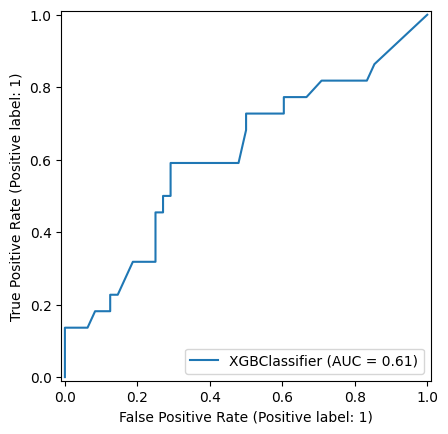

In [94]:
# @title Optuna для XGBoostClassifier
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 20, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 9.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 1.5),
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params, random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_boost, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return np.mean(scores)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, timeout=1800)

print("Best trial:")
print("AUC:", study.best_value)
print("Params:", study.best_params)

best_params = study.best_params
best_params['eval_metric'] = 'logloss'
model = XGBClassifier(**best_params, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

[I 2025-07-11 13:09:33,725] A new study created in memory with name: no-name-756b75e6-f74f-4921-b2ae-ad2c96c8313c


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-07-11 13:09:37,615] Trial 0 finished with value: 0.6885320037105751 and parameters: {'iterations': 566, 'learning_rate': 0.17716879877469666, 'depth': 3, 'l2_leaf_reg': 3.112226312924084, 'random_strength': 8.119316244653064, 'bagging_temperature': 0.792371745598231, 'border_count': 132, 'scale_pos_weight': 0.7353060969874805}. Best is trial 0 with value: 0.6885320037105751.
[I 2025-07-11 13:09:43,705] Trial 1 finished with value: 0.7200021350531554 and parameters: {'iterations': 691, 'learning_rate': 0.20802574543234628, 'depth': 6, 'l2_leaf_reg': 4.733914889760288, 'random_strength': 2.881343776446758, 'bagging_temperature': 0.10760378140058735, 'border_count': 250, 'scale_pos_weight': 0.6004134628346398}. Best is trial 1 with value: 0.7200021350531554.
[I 2025-07-11 13:09:44,069] Trial 2 finished with value: 0.7010969755867714 and parameters: {'iterations': 129, 'learning_rate': 0.15805152968136948, 'depth': 4, 'l2_leaf_reg': 5.1145752287000565, 'random_strength': 5.15650512

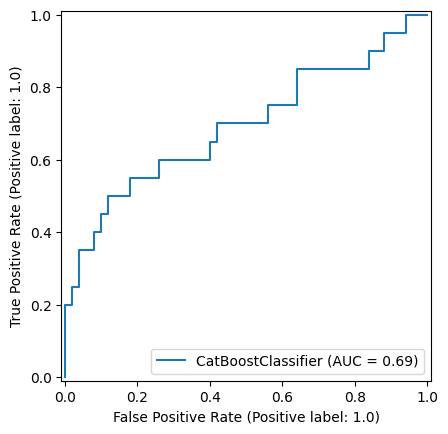

In [229]:
# @title Optuna для CatBoostClassifier
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 2.0),
        "verbose": False,
        "loss_function": "Logloss",
        "eval_metric": "Recall",
        "random_seed": 42,
        "early_stopping_rounds": 50
    }

    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X_boost, y, cv=cv, scoring="roc_auc")
    return np.mean(auc_scores)

# Запуск Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("Лучшие параметры:\n", study.best_params)

# Финальная модель с лучшими параметрами
best_params = study.best_params
best_params.update({
    "loss_function": "Logloss",
    "eval_metric": "Recall",
    "random_seed": 42,
    "early_stopping_rounds": 50,
    "verbose": 100
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

# Оценка
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# AUC
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

In [252]:
dfrf = df_final
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

feat_selector = BorutaPy(
    estimator=rf,
    n_estimators='auto',
    max_iter=1000,
    random_state=0,
    verbose=False
)

feat_selector.fit(dfrf.values, y.values)

selected_mask = feat_selector.support_
selected_features = dfrf.columns[selected_mask]

print("\nОтобранные признаки методом Boruta:")
print(selected_features.tolist())


Отобранные признаки методом Boruta:
['HR stress', 'HRR', 'LVESVi stress', 'LVEF% stress', 'GLS stress-', 'D WMSI']
